/Users/Gorkem/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


Number of data points - train: 2951, test: 1266
Time to read data: 0.027270933000000497 seconds
Time to preprocess 2951 data points: 0.4522040829999998 seconds
Time for stemming 2951 data points: 1.382492946000001 seconds
Time to preprocess 1266 data points: 0.18747677100000004 seconds
Time for stemming 1266 data points: 0.7764718169999991 seconds
training_data_text_sparse shape with stopwords= (2951, 5166)
training_data_text_sparse shape without stopwords= (2951, 4981)
['be', 'them', 'within', 'five', 'all', 'and', 'around', 'had', 'it', 'again', 'here', 'they', 'much', 'own', 'ever', 'should', 'with', 'over', 'due', 'find', 'then', 'side', 'less', 'seem', 'us', 'on', 'among', 'bottom', 'will', 'can', 'are', 'most', 'whether', 'about', 'those', 'still', 'up', 'ten', 'might', 'bill', 'against', 'each', 'even', 'how', 'cant', 'were', 'is', 'four', 'may', 'former', 'per', 'under', 'their', 'move', 'him', 'in', 'her', 'fill', 'these', 'thin', 'system', 'almost', 'amount', 'enough', 'call'

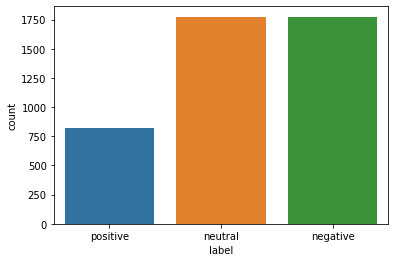

In [1]:

import pandas
import re
import string
from timeit import default_timer as timer

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.stem import PorterStemmer
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
import seaborn as sns

def read_data():
    """
    Read train/test data

    Returns:
    train -- Training dataframe, with 'sentence' and 'label'
    test -- Testing dataframe, with 'sentence' and 'label'
    """
    start = timer()
    train = pandas.read_csv("training.tsv", sep = "\t", encoding = "utf-8")
    test = pandas.read_csv("testing.tsv", sep = "\t", encoding = "utf-8")
  
    
    end = timer()
    print ("Number of data points - train: {}, test: {}".format(train.shape[0], test.shape[0]))
    print ("Time to read data: {} seconds".format(end - start))
    
    sns.countplot(x='label', data=train)
    
    return train, test


def preprocess_data(df):
    """
    Preprocess data:
    -- strip spaces and lowercase
    -- get rid of numbers
    -- get rid of punctuations
    -- get rid of single letters

    Keyword arguments:
    df -- Input two column dataframe with 'sentence' and 'label'

    Returns:
    df -- With preprocessed 'sentence' column and 'label'
    """

    def preprocessor(sentence):
        sentence = sentence.strip().lower()
        sentence = re.sub(r"\d+", "", sentence)
        sentence = sentence.translate(sentence.maketrans(string.punctuation, ' '*len(string.punctuation)))
        sentence = " ".join([w for w in nltk.word_tokenize(sentence) if len(w) > 1])
        
        return sentence

    start = timer()
    df["sentence"] = df["sentence"].apply(preprocessor)

    end = timer()
    print ("Time to preprocess {} data points: {} seconds".format(df.shape[0], end - start))
    return df


def stemmed_text(df):
    
    from nltk.tokenize import sent_tokenize, word_tokenize
    porter = PorterStemmer()
    def stemSentence(sentence):
        token_words=word_tokenize(sentence)
        stem_sentence=[]
        for word in token_words:
            stem_sentence.append(porter.stem(word))
            stem_sentence.append(" ")
        return "".join(stem_sentence)
        

    start = timer()
    df["sentence"] = df["sentence"].apply(stemSentence)

    end = timer()
    print ("Time for stemming {} data points: {} seconds".format(df.shape[0], end - start))


    return df


def train_clf(df):
    
    """
    Train classifier
    -- logistic regression
    -- with TFIDF features

    Keyword arguments:
    df -- Input two column dataframe with 'sentence' and 'label'

    Returns:
    vec -- Fitted vectorizer
    clf -- Fitted classifier
    """
    
    start = timer()
    vec = TfidfVectorizer(max_features = 6000)
    training_data_text_sparse = vec.fit_transform(df["sentence"])
    
    print("training_data_text_sparse shape with stopwords=", training_data_text_sparse.shape)
    
    A= vec.get_feature_names()
    
    vec2 = TfidfVectorizer(max_features = 6000,stop_words='english')
    training_data_text_sparse2 = vec2.fit_transform(df["sentence"])
    B= vec2.get_feature_names()
    
    print("training_data_text_sparse shape without stopwords=", training_data_text_sparse2.shape)
    
    print(list(set(A) - set(B)))
    
    
    
    """
    print(df["sentence"][1])
    print([training_data_text_sparse[1,vec.vocabulary_['industri']]])
    print([training_data_text_sparse[1,vec.vocabulary_['custom']]])
    print([training_data_text_sparse[1,vec.vocabulary_['individu']]])
    print([training_data_text_sparse[1,vec.vocabulary_['it']]])
    print(training_data_text_sparse)
   
    print("training_data_text_sparse shape=", training_data_text_sparse.shape)
    """
    
    print("Shape Before Smote=",df["label"].shape)
    #SMOTE
    sm = SMOTE('minority',random_state=4)
    #sm = SMOTE('not majority',random_state=4)
    #sm = SMOTE('auto',random_state=4)
    sm_xtrain_tfidf, sm_train_y = sm.fit_sample(training_data_text_sparse, df["label"])
    print("Shape After Smote=",sm_train_y.shape)
    
    sns.countplot(x=sm_train_y, data=df)
    
    clf = LinearSVC(C=0.39,random_state = 42)
    clf.fit(sm_xtrain_tfidf, sm_train_y)
    
    end = timer()
    print ("Time to train on {} data points: {} seconds".format(df.shape[0], end - start))

    return vec, clf


def evaluate_clf(vec, clf, df):
    """
    Calculate classification performance on test set
    
    Keyword arguments:
    vec -- Fitted vectorizer
    clf -- Fitted classifier
    df -- Two column test dataframe with 'sentence' and 'label'
    """
    start = timer()
    testing_data_text_sparse = vec.transform(df["sentence"])
    pred = clf.predict(testing_data_text_sparse)
    
    print ("shape test= {} shape pred= {} ".format(test.shape, pred.shape))
    import numpy as np
    a=np.array(test)
    pred=pred.reshape(1266,1)
    
    b=np.append(a, pred, axis=1)
    print("b shape=",b.shape)
    #print("b=",b)
    #print(test.loc[13,:])
    print(b[0])
    #print ("Sentence= {} Actual= {} Pred= {}".format(df["sentence"], df["label"],pred))
    
    end = timer()
    print ("Time to apply classifier on {} data points: {} seconds".format(df.shape[0], end - start))

    print ("\nTest Report:")
    print (classification_report(df["label"], pred, digits = 4))

def load_model(clf):
    
    import pickle
    pickle.dump(clf,open("LinSVC.pkl","wb"))
    my_class_model=pickle.load(open("LinSVC.pkl","rb"))
    print(my_class_model)
    

if __name__ == "__main__":
    train, test = read_data()
    train = preprocess_data(train)
    train = stemmed_text(train)
    test = preprocess_data(test)
    test = stemmed_text(test)
    vec, clf = train_clf(train)
    evaluate_clf(vec, clf, test)
    load_model(clf)
    
    
    """
    Baseline Model Report:
              precision    recall  f1-score   support

    negative     0.5789    0.5000    0.5366       154
     neutral     0.7844    0.9277    0.8501       761
    positive     0.7725    0.5128    0.6164       351

    accuracy                         0.7607      1266
    macro avg    0.7120    0.6468    0.6677      1266
weighted avg     0.7561    0.7607    0.7472      1266


    LinearSVC Model Report:
                  precision    recall  f1-score   support

    negative     0.6810    0.7208    0.7003       154
     neutral     0.8453    0.9120    0.8774       761
    positive     0.8227    0.6610    0.7330       351

    accuracy                         0.8191      1266
   macro avg     0.7830    0.7646    0.7702      1266
weighted avg     0.8191    0.8191    0.8158      1266

    """
